#Connecting to Google Drive!

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Required Libraries!

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

#Dataset Paths!

In [6]:
train_dir = "/content/drive/My Drive/ECG_DATA_NEW/train"
test_dir  = "/content/drive/My Drive/ECG_DATA_NEW/test"

classes = os.listdir(train_dir)
print("Classes found:", classes)

Classes found: ['Myocardial Infarction', 'Abnormal heartbeat', 'Normal Person', 'History of Myocardial Infarction']


#Sample Images!

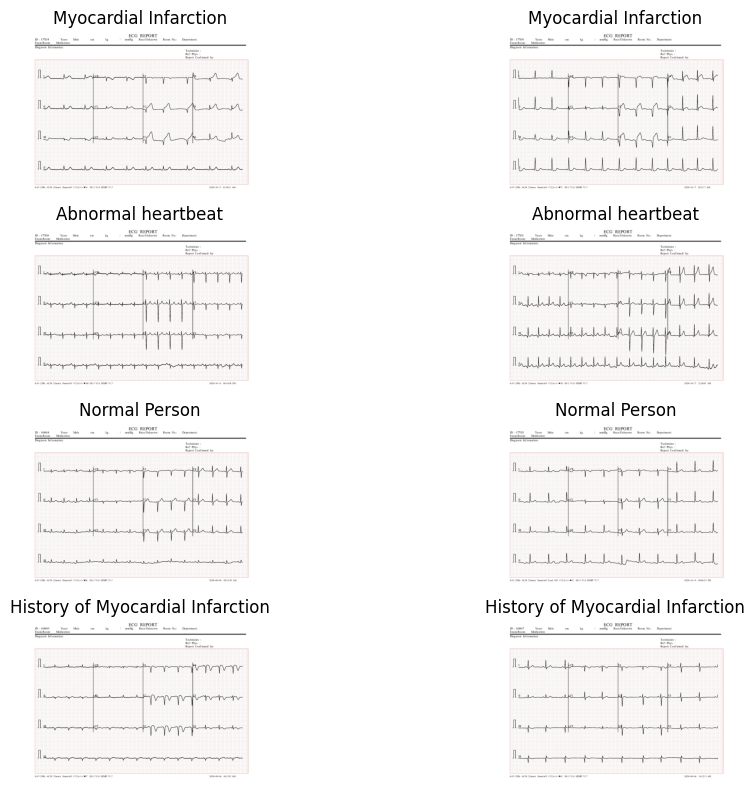

In [7]:
plt.figure(figsize=(12, 8))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_files = os.listdir(cls_path)[:2]

    for j, img_name in enumerate(img_files):
        img_path = os.path.join(cls_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(classes), 2, i*2 + j + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

plt.tight_layout()
plt.show()

#Image Resizing!

In [8]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
).flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 744 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


#Building EfficientNetB0 Model!

In [9]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#Showing Classes Names!

In [ ]:
for cls in classes:
    count = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"{cls}: {count} images")


Myocardial Infarction: 239 images
Abnormal heartbeat: 233 images
Normal Person: 283 images
History of Myocardial Infarction: 172 images


# Unfreeze last 100 layers of EfficientNet!

In [10]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#Training Model!

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/content/drive/My Drive/ECG_DATA_NEW/efficientnetb0_best_final_fixed.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3946 - loss: 1.2885
Epoch 1: val_accuracy improved from -inf to 0.28415, saving model to /content/drive/My Drive/ECG_DATA_NEW/efficientnetb0_best_final_fixed.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 286s 11s/step - accuracy: 0.3978 - loss: 1.2840 - val_accuracy: 0.2842 - val_loss: 1.3730 - learning_rate: 1.0000e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7455 - loss: 0.8021
Epoch 2: val_accuracy improved from 0.28415 to 0.39891, saving model to /content/drive/My Drive/ECG_DATA_NEW/efficientnetb0_best_final_fixed.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.7458 - loss: 0.8005 - val_accuracy: 0.3989 - val_loss: 1.3137 - learning_rate: 1.0000e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8164 - loss: 0.6124
Epoch 3: val_accuracy improved from 0.39891 to 0.45355, saving model to /content/drive/My Drive/ECG_DATA_NEW/efficientnetb0_best_final_fixed.keras
24/24 ━━━━━━━━━━━━━━━━━━

#Plot Training Curves!

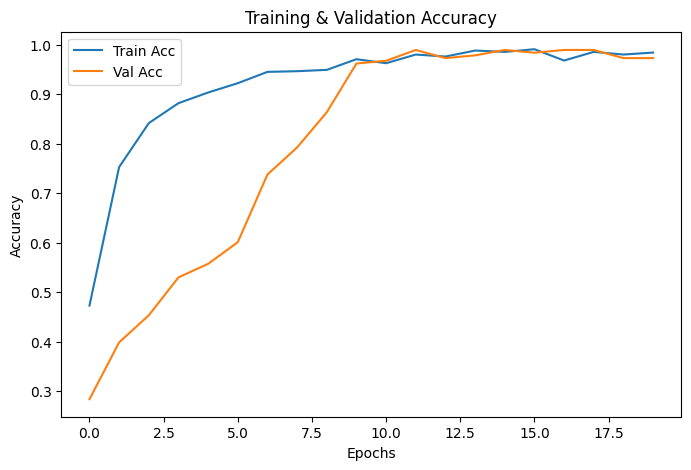

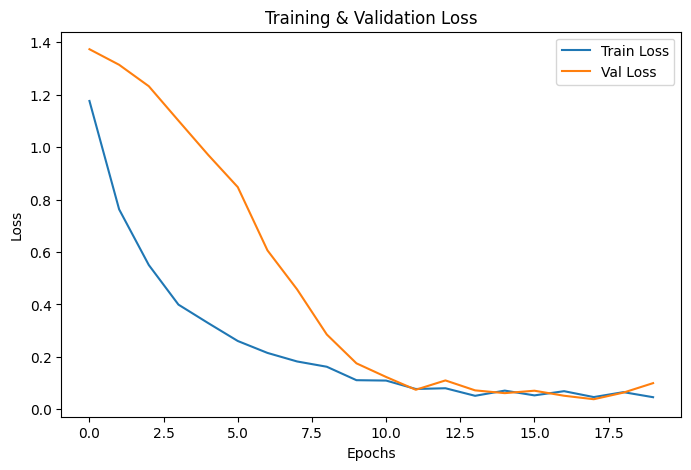

In [13]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

#Evaluating on Test Set!

Found 928 images belonging to 4 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step - accuracy: 0.9927 - loss: 0.0254
Test Accuracy: 99.78%
Test Loss: 0.0121
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step

Classification Report:

                                  precision    recall  f1-score   support

              Abnormal heartbeat       1.00      0.99      1.00       233
History of Myocardial Infarction       0.99      1.00      1.00       172
           Myocardial Infarction       1.00      1.00      1.00       239
                   Normal Person       1.00      1.00      1.00       284

                        accuracy                           1.00       928
                       macro avg       1.00      1.00      1.00       928
                    weighted avg       1.00      1.00      1.00       928



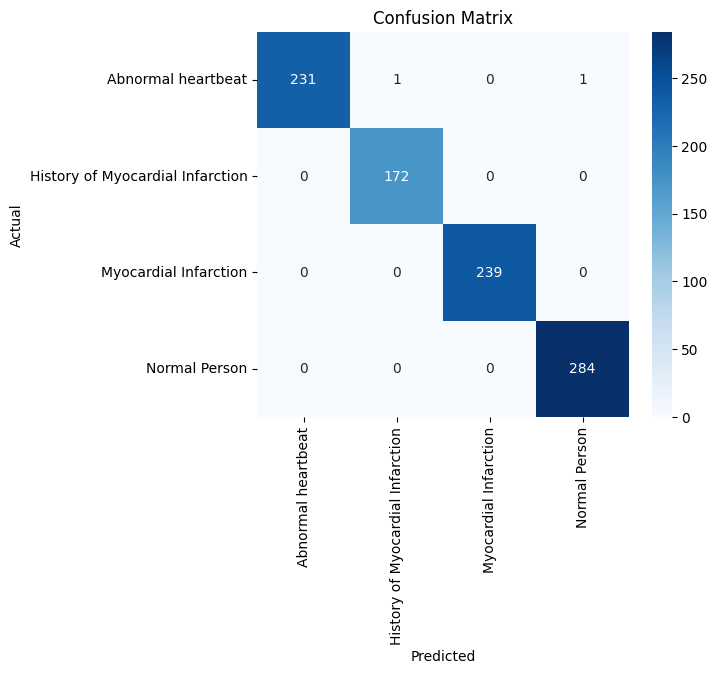

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#Predicting on Single Image!

In [15]:
def predict_ecg_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class]

    print(f"Predicted Disease: {predicted_label}")
    return predicted_label

test_image_path = "/content/drive/My Drive/ECG_DATA_NEW/test/Myocardial Infarction/MI(8).jpg"
predict_ecg_image(test_image_path, model, test_gen.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Disease: Myocardial Infarction


'Myocardial Infarction'